In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb

bst = xgb.Booster()
bst.load_model('xgboost_model.json')

In [17]:
def rule(df_btc, df, tp=1, sl=5, money=1000):
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []


    index_condition = []
    for i in range(40, len(df)-1, 10):
        x_array = df.iloc[i-30:i].values[:,1:].astype(np.float32)

        x_array[:,-1] = x_array[:,-1]/20000
        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)


        x_array = np.array([x_array]).reshape(1, -1)
        dtest = xgb.DMatrix(x_array)
        y_pred_prob = bst.predict(dtest)
        if y_pred_prob >= 0.5:
            index_condition.append(i)

    index_condition = sorted(index_condition)
    for i in index_condition:
        a = df['open'].iloc[i]
        high_check = False
        low_check = False
        for j in range(i, len(df)):
            # if j >= len(df):
            #     break
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * a
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * a
            if high_check and low_check:
                print("check lai")
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1

                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "low"))
                break
        if not high_check and not low_check:
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)
    return money  *   (number_low * tp/100 + number_high * -sl/100),cannot_break, results, index_condition, number_high, number_low, list_reward, prices_list


In [5]:
start = "2023-06-12"
end = "2024-08-11"
df_all = []
symb = "ORDIUSDT"
interval = "15m"
df_all = pd.read_csv(f"{symb}_{start}_{end}_{interval}.csv")

In [7]:
df_all[df_all['timestamp']=="2024-08-08 09:00:00"]

,timestamp,open,high,low,close,volumn
26360,2024-08-08 09:00:00,26.61,27.41,26.61,27.37,78585.16


In [19]:
df = df_all.iloc[10000:].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1))
display(df.tail(2))
reward, cb, rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3)
reward

,timestamp,open,high,low,close,volumn
0,2024-02-19 23:00:00,70.167,70.247,70.0,70.08,7056.04


,timestamp,open,high,low,close,volumn
16515,2024-08-09 23:45:00,27.61,27.67,27.48,27.67,6915.32
16516,2024-08-10 00:00:00,27.67,27.81,27.60,27.80,2958.34


num points:  865 number_low/all_point 0.683 cannot_break 0


9510.0

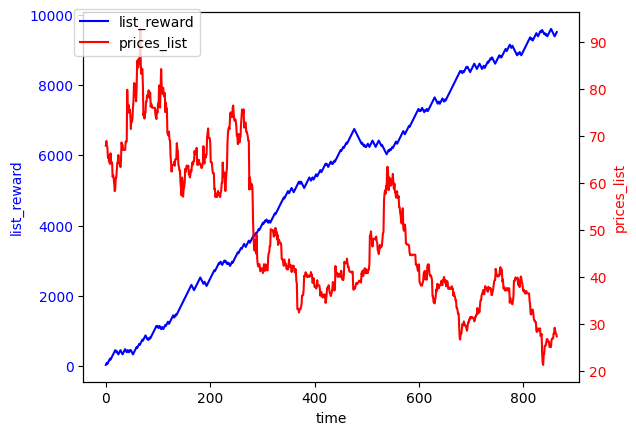

In [20]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(list_reward, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()